<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/04_Retrieve_Data_from_Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Pre-Requisites

This notebook demonstrates how to create an index and retrieve data from Knowledge graph using Neo4j GraphRAG Module

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 105 (delta 54), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (105/105), 1.04 MiB | 3.97 MiB/s, done.
Resolving deltas: 100% (54/54), done.


## Install Required Packages

In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.3 MB/s et

## Load credentials from .env

In [ ]:
import os
os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv

load_dotenv()  # This loads .env at project root

NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize the Neo4j Driver
The Neo4j driver allows you to connect and perform read and write transactions with the database.

In [ ]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
)

# (Optional) Test the connection
driver.verify_connectivity()

## Initialize OpenAI LLM and Embeddings via neo4j-graphrag
We will use OpenAI **GPT-4.1**. The GraphRAG Python package supports any LLM model, including models from OpenAI, Google VertexAI, Anthropic, Cohere, Azure OpenAI, local Ollama models, and any chat model that works with LangChain. You can also implement a custom interface for any other LLM.

Likewise, we will use OpenAI’s **text-embedding-3-small** for the embedding model, but you can use other embedders from different providers.

In [ ]:
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings

llm = OpenAILLM(
    model_name="gpt-4.1",
    model_params={"temperature": 0}
)

json_llm = OpenAILLM(
    model_name="gpt-4.1",
    model_params={"temperature": 0,
                  "response_format": {"type": "json_object"}
                  }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

In [ ]:
# Test llm call
llm.invoke("why is sky blue?")

LLMResponse(content='The sky appears blue because of a phenomenon called **Rayleigh scattering**.\n\nHere’s how it works:\n\n- **Sunlight** looks white, but it’s actually made up of many colors (red, orange, yellow, green, blue, indigo, violet).\n- As sunlight passes through Earth’s atmosphere, it collides with molecules and tiny particles in the air.\n- **Blue light** has a shorter wavelength and is scattered in all directions much more than other colors with longer wavelengths (like red or yellow).\n- This scattered blue light is what we see when we look up, making the sky appear blue.\n\nAt sunrise and sunset, the sky can look red or orange because the sun is lower in the sky, and its light passes through more atmosphere. This scatters away the blue and lets the reds and oranges dominate.\n\n**In summary:**  \nThe sky is blue because blue light from the sun is scattered in all directions by the gases and particles in the atmosphere, and this scattered blue light is what we see.')

## Initialize Langfuse Handler for Tracing

In [ ]:
from langfuse.langchain import CallbackHandler
from langfuse import get_client

os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

langfuse_handler = CallbackHandler()

# Create a Vector & Fulltext Index

We can create a vector index in Neo4j to allow this retriever to pull back information from the nodes.

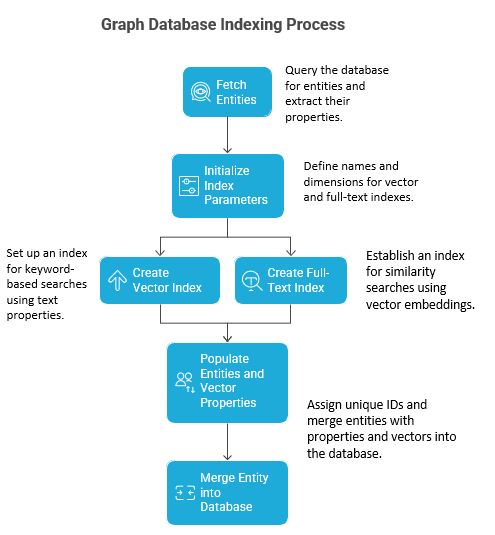

-This code interacts with a Neo4j graph database to create and populate indexes for efficient data retrieval.

  Here's a breakdown:

  - **Fetch Entities:** It starts by querying the database for nodes labeled __Entity__ and extracts their properties.

  - **Initialize Index Parameters:** It defines names for a vector index (entity_vector_index) and a full-text index (entity_fulltext_index), along with the dimension size for the vector embeddings (1536).

  - **Create Vector Index:** It creates a vector index on the __Entity__ label, using the vectorProperty for embeddings and cosine similarity. This index allows for efficient similarity searches based on the vector representations of the entities.

  - **Create Full-Text Index:** It creates a full-text index on the __Entity__ label, indexing various text properties like location, theme, bio, etc. This index enables fast keyword-based searches.

  - **Populate Entities and Vector Properties:** It iterates through the fetched entities. If an entity doesn't have an id, it assigns a new UUID. It then prepares the entity properties and its corresponding vector (if it exists).

  Finally, it uses a Cypher query to merge the entity into the database (creating it if it doesn't exist), setting its properties and the vector property.
  
  In essence, this code prepares the graph database for efficient searching by creating specialized indexes and ensuring that entities have unique identifiers and associated vector embeddings.



In [ ]:
import uuid
from neo4j_graphrag.indexes import create_fulltext_index, create_vector_index

def fetch_entities(driver):
    """Fetches entities from the Neo4j database."""
    cypher = """MATCH (n:__Entity__)
    RETURN properties(n) AS props
    """
    with driver.session() as session:
        results = session.run(cypher).data()
    return [record["props"] for record in results]

def create_indexes(driver, dimension):
    """Creates vector and full-text indexes in the Neo4j database."""
    INDEX_NAME = "entity_vector_index"
    FULLTEXT_INDEX_NAME = "entity_fulltext_index"

    create_vector_index(
        driver,
        INDEX_NAME,
        label="__Entity__",
        embedding_property="vectorProperty",
        dimensions=dimension,
        similarity_fn="cosine",
    )

    create_fulltext_index(
        driver,
        FULLTEXT_INDEX_NAME,
        label="__Entity__",
        node_properties=["location", "theme", "bio", "text", "description", "name", "title", "year", "tools_used",
                         "level", "organization", "is_speaker", "designation", "linkedin_url", "duration", "start_time",
                         "type", "role", "awards", "category", "industry", "tools_discussed", "website"
                         ]
    )

def populate_entities(driver, entities):
    """Populates entities and their vector properties in the Neo4j database."""
    for entity in entities:
        if not entity.get("entity_id"):
            entity["entity_id"] = str(uuid.uuid4())
        props = entity.copy()
        vector = props.pop("embedding", None)
        params = {"props": props}

        if vector is not None:
            params["vector"] = vector
            driver.execute_query("""
            MERGE (n:__Entity__ {entity_id: $props.entity_id})
            SET n += $props
            WITH n
            CALL db.create.setNodeVectorProperty(n, 'vectorProperty', $vector)
            RETURN n
            """, params)
        else:
            driver.execute_query("""
            MERGE (n:__Entity__ {entity_id: $props.entity_id})
            SET n += $props
            RETURN n
            """, params)



# Main execution
DIMENSION = 1536  # your embedding size

entities = fetch_entities(driver)
create_indexes(driver, DIMENSION)
populate_entities(driver, entities)

# Retrieve Data from Knowledge Graph

The GraphRAG Python package provides multiple classes for retrieving data from your knowledge graph, including:

- **Vector Retriever:** performs similarity searches using vector embeddings

- **Vector Cypher Retriever:** combines vector search with retrieval queries in Cypher, Neo4j’s Graph Query language, to traverse the graph and incorporate additional nodes and relationships.

- **Hybrid Retriever:** Combines vector and full-text search.

- **Hybrid Cypher Retriever:** Combines vector and full-text search with Cypher retrieval queries for additional graph traversal.

- **Text2Cypher:** converts natural language queries into Cypher queries to run against Neo4j.

## Vector Retriever

The Vector Retriever uses Approximate Nearest Neighbor (ANN) vector search to retrieve data from your knowledge graph.

You can then instantiate the vector retriever using the code below:

In [ ]:
from neo4j_graphrag.retrievers import VectorRetriever

vector_retriever = VectorRetriever(
   driver,
   index_name="entity_vector_index",
   embedder=embedder,
   #return_properties=["text"],
)

Now, let’s run this retriever with a simple prompt. The retriever can pull back text chunks and vector similarity scores, providing some useful context for answering questions in RAG.

In [ ]:
import json

vector_res = vector_retriever.get_search_results(query_text = "Which Sessions talk about Agentic AI?",
             top_k=3)
for i in vector_res.records: print("====n" + json.dumps(i.data(), indent=4))

====n{
    "node": {
        "louvain": 108,
        "name": "Agentic AI",
        "vectorProperty": null,
        "embedding": [
            -0.011101040989160538,
            0.016288241371512413,
            -0.021669693291187286,
            0.03211604058742523,
            0.021669693291187286,
            -0.013698238879442215,
            -0.01327376626431942,
            0.047051724046468735,
            0.0016754083335399628,
            -0.007349133957177401,
            0.009640567004680634,
            -0.03151170536875725,
            -0.0001938005880219862,
            -0.06095140799880028,
            -0.031540483236312866,
            -0.027310144156217575,
            -0.030389370396733284,
            -0.061008963733911514,
            0.021050971001386642,
            -0.06526807695627213,
            0.03113759309053421,
            0.01823074370622635,
            -0.00399292167276144,
            0.03959827125072479,
            -0.03864860162138939,
            0

## Vector Cypher Retriever

Another useful retriever to explore is the Vector Cypher Retriever, which lets you use Cypher, Neo4j’s graph query language, to incorporate graph traversal logic after retrieving an initial set of nodes with vector search. Below we create a retriever to obtain relevant nodes via vector search, then traversing out on entities up to 3 hops out.

In [ ]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

vc_retriever = VectorCypherRetriever(
   driver,
   index_name="entity_vector_index",
   embedder=embedder,
   retrieval_query = """MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN w.title AS name, w.description AS description, w.duration AS duration, w.start_time AS start_time
UNION
MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN s.title AS name, s.description AS description, NULL AS duration, NULL AS start_time"""
)

Submitting the same prompt, here’s the context we get back:

In [ ]:
vc_res = vc_retriever.get_search_results(query_text = "List down all the sessions or workshops which uses LangGraph?", top_k=3)

# print output
vc_res

RawSearchResult(records=[<Record name='LLMOps – Productionalizing Real-World Applications with LLMs and Agents' description="Ready to go from experimentation to production with LLMs? This hands-on session will guide you through training language models using HuggingFace, building Retrieval Augmented Generation (RAG) pipelines with Qdrant, and deploying automated training workflows on Amazon SageMaker. You'll also learn how to orchestrate multi-agent workflows using LangGraph and test, monitor, and evaluate your models with LangSmith. Through practical labs, participants will build end-to-end, production-ready GenAI systems that prioritize scalability, reliability, and real-world performance, equipping you with the tools to operationalize LLMs with confidence." duration=['8h', '8 hours'] start_time='09:30AM'>, <Record name='AgentOps: Building and Deploying AI Agents' description="This workshop introduces AgentOps, a subcategory of GenAIOps, which focuses on the operationalization of AI 

### Limitations of Vector Retrieval

**Domain-specific limitations**: Vector search can struggle with domain-specific terms or jargon that are not well-represented in the embedding model’s training data.

**Not ideal for precise string matching**: It may not accurately find results when the query depends on exact matches for specific names, numbers, or dates.


## Full-Text Indexes
Fortunately, there is a solution to this issue: full-text indexes. Unlike vector indexes, which match strings based on semantic similarity, full-text indexes match pieces of text based on lexical similarity, meaning they compare the exact wording or text structure.

## Hybrid Retriever




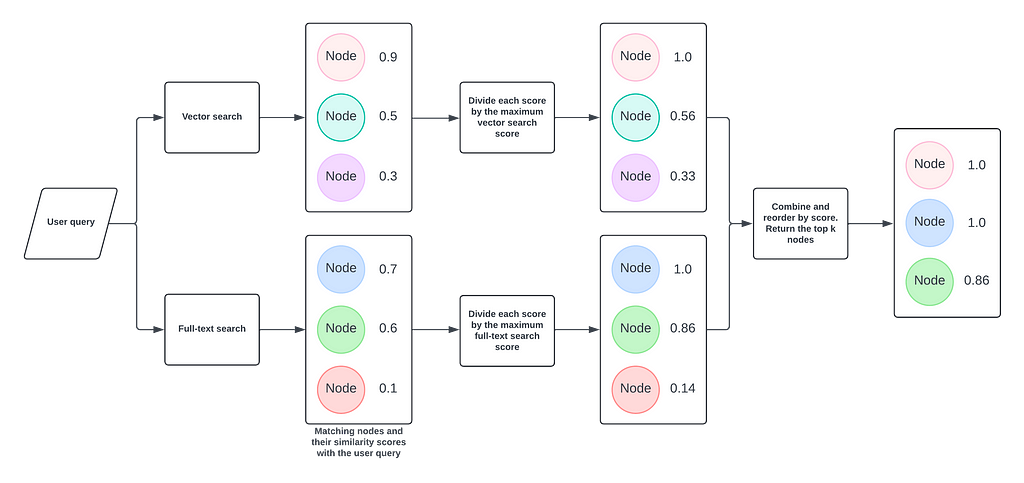

We can use full-text indexes for our GraphRAG applications by using the HybridRetriever class from the Neo4j GraphRAG Python library. This retriever leverages both a vector index and a full-text index in a process known as hybrid search. It uses the user query to search both indexes, retrieving nodes and their corresponding scores. After normalizing the scores from each set of results, it merges them, ranks the combined results by score, and returns the top matches.

In [ ]:
from neo4j_graphrag.retrievers import HybridRetriever

hybrid_retriever = HybridRetriever(
    driver=driver,
    vector_index_name="entity_vector_index",
    fulltext_index_name="entity_fulltext_index",
    embedder=embedder,
    #return_properties=["title", "plot"],
)

query_text = "Who is delivering a workshop on Agentic RAG?"

retriever_result = hybrid_retriever.search(query_text=query_text, top_k=3)
print(retriever_result)

items=[RetrieverResultItem(content='{\'duration\': \'8 hours\', \'title\': \'Agentic RAG Workshop: From Fundamentals to Real-World Implementations\', \'instructor\': \'Arun Prakash Asokan\', \'level\': \'Intermediate\', \'prerequisites\': [\'Basic Python skills\', \'Introductory level exposure to LLMs and RAG\', \'Familiarity with LangChain or similar frameworks\', \'Exposure to vector databases and embeddings\'], \'louvain\': 94, \'description\': ["This workshop is a deep dive into Agentic RAG (Retrieval-Augmented Generation) - an emerging approach that combines the power of LLM-based agents with retrieval techniques to build smarter AI applications. Over an 8-hour session, participants will explore how to move beyond \'vanilla\' RAG pipelines and infuse them with agentic behavior for greater flexibility and intelligence. The workshop is hands-on, using Google Colab notebooks for each module so attendees can practice concepts live. We\'ll leverage LangGraph (a LangChain-based framewor

## Hybrid Cypher Retriever
The HybridCypherRetriever enhances the hybrid search process by adding a graph traversal step. It begins by identifying an initial set of nodes through a combined search over vector and full-text indexes, then uses a specified Cypher query to retrieve additional information from the graph for each of these nodes.

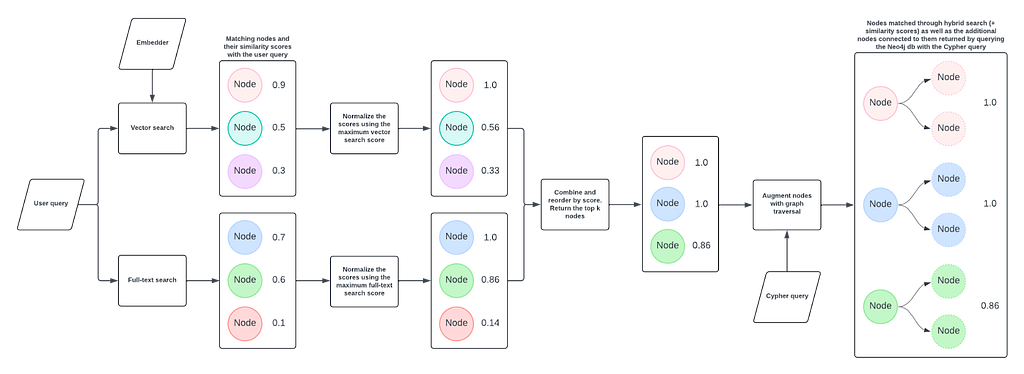

To make use of this retriever, we first need to write a Cypher query to specify exactly what additional information to fetch along with each of the nodes retrieved through hybrid search. Given we are looking to answer questions about actors in movies, we can use the following query:

In [ ]:
retrieval_query = """MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN w.title AS name, w.description AS description, w.duration AS duration, w.start_time AS start_time
UNION
MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN s.title AS name, s.description AS description, NULL AS duration, NULL AS start_time"""

We then pass this query to the HybridCypherRetriever with the names of the vector and full-text indexes we want to search.

In [ ]:
from neo4j_graphrag.retrievers import HybridCypherRetriever

hc_retriever = HybridCypherRetriever(
    driver=driver,
    vector_index_name="entity_vector_index",
    fulltext_index_name="entity_fulltext_index",
    retrieval_query=retrieval_query,
    embedder=embedder,
)
query_text = "List down all the sessions or workshops which uses LangGraph?"
retriever_result = hc_retriever.search(query_text=query_text, top_k=3)
print(retriever_result)

items=[RetrieverResultItem(content='<Record name=\'LLMOps – Productionalizing Real-World Applications with LLMs and Agents\' description="Ready to go from experimentation to production with LLMs? This hands-on session will guide you through training language models using HuggingFace, building Retrieval Augmented Generation (RAG) pipelines with Qdrant, and deploying automated training workflows on Amazon SageMaker. You\'ll also learn how to orchestrate multi-agent workflows using LangGraph and test, monitor, and evaluate your models with LangSmith. Through practical labs, participants will build end-to-end, production-ready GenAI systems that prioritize scalability, reliability, and real-world performance, equipping you with the tools to operationalize LLMs with confidence." duration=[\'8h\', \'8 hours\'] start_time=\'09:30AM\'>', metadata=None), RetrieverResultItem(content='<Record name=\'AgentOps: Building and Deploying AI Agents\' description="This workshop introduces AgentOps, a sub

## Text2Cypher Retriever

This retriever first asks an LLM to generate a Cypher query to fetch the exact information required to answer the question from the database. Then this query is executed and the resulting records are added to the context for the LLM to write the answer to the initial user question.

The workflow for generating Cypher queries from natural language questions can
be broken down into the following steps:
- Retrieve the question from the user.
- Retrieve the schema of the knowledge graph.
- Define other useful information like terminology mappings, format instructions, and few-shot examples.
- Generate the prompt for the LLM.
- Pass the prompt to the LLM to generate the Cypher query.


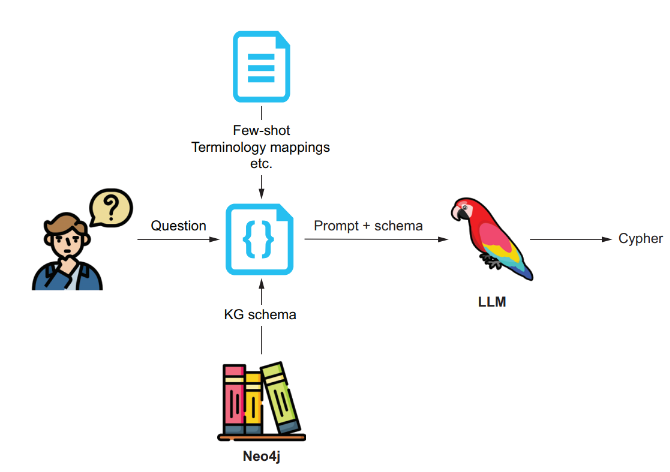

In [ ]:
from neo4j_graphrag.retrievers import Text2CypherRetriever
import prompts
from examples import examples
from neo4j_graphrag.schema import get_schema

# Initialize the Text2Cypher retriever
t2c_retriever = Text2CypherRetriever(
    llm=llm,
    neo4j_schema=get_schema(driver),
    driver=driver,
    custom_prompt=prompts.custom_text2cypher_prompt,
    examples=examples
)

# Define a sample query in natural language
query_text = "List the titles of all workshops."

# Use the retriever to convert the natural language query to a Cypher query and execute it
response = t2c_retriever.search(query_text=query_text)

# Print the generated Cypher query and the results
print("Generated Cypher Query:")
print(response.metadata['cypher'])
print("\nResults:")
for record in response.items:
    print(record.content)

Generated Cypher Query:
MATCH (w:Workshop)
RETURN DISTINCT w.title

Results:
<Record w.title='Mastering Real-World Agentic AI Applications with AG2 (AutoGen)'>
<Record w.title='LLMOps – Productionalizing Real-World Applications with LLMs and Agents'>
<Record w.title='AgentOps: Building and Deploying AI Agents'>
<Record w.title='Mastering LLMs: Training, Fine-Tuning, and Best Practices'>
<Record w.title='From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents'>
<Record w.title='Mastering Real-World Multi-Agent Systems'>
<Record w.title='Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language'>
<Record w.title='Agentic RAG Workshop: From Fundamentals to Real-World Implementations'>
<Record w.title='Agentic AI & Generative AI for Business Leaders'>
<Record w.title='Training Mini AI Agents with Small Language Models'>
<Record w.title='Mastering Intelligent Agents: A Deep Dive into Agentic AI'>


# GraphRAG

To turn the retriever search into a full GraphRAG pipeline, we simply add the following code:

In [ ]:
from neo4j_graphrag.generation import GraphRAG
from IPython.display import display, Markdown
import json

def query_graph(retriever, llm, query_text, retriever_config):
  """Queries the graph using a GraphRAG pipeline.

  Args:
    retriever: The retriever to use.
    llm: The language model to use.
    query_text: The query text.
    retriever_config: The retriever configuration.

  Returns:
    The response from the GraphRAG pipeline.
  """
  # Initialize the RAG pipeline
  rag = GraphRAG(retriever=retriever, llm=llm)

  # Query the graph
  response = rag.search(query_text=query_text,
                        retriever_config=retriever_config,
                        return_context=True,
                        response_fallback="I can not answer this question because I have no relevant context.",
                        config={"callbacks": [langfuse_handler]}
                        )
  return response.answer

query_text = "List down all the sessions or workshops which uses LangGraph?"
top_k_value = 5

# Get results from Vector Retriever using query_graph function
display(Markdown("### Vector Retriever Results (using GraphRAG)"))
response = query_graph(vector_retriever, llm, query_text, {"top_k": top_k_value})
display(Markdown(response))

# Get results from Vector Cypher Retriever using query_graph function
display(Markdown("### Vector Cypher Retriever Results (using GraphRAG)"))
response = query_graph(vc_retriever, llm, query_text, {"top_k": top_k_value})
display(Markdown(response))

# Get results from Text2Cypher Retriever using the query_graph function
display(Markdown("### Text2Cypher Retriever Results (using GraphRAG)"))
response = query_graph(t2c_retriever, llm, query_text, {})
display(Markdown(response))

# Get results from Hybrid Retriever using query_graph function
display(Markdown("### Hybrid Retriever Results (using GraphRAG)"))
response = query_graph(hybrid_retriever, llm, query_text, {"top_k": top_k_value})
display(Markdown(response))

# Get results from Hybrid Cypher Retriever using the query_graph function
display(Markdown("### Hybrid Cypher Retriever Results (using GraphRAG)"))
response = query_graph(hc_retriever, llm, query_text, {"top_k": top_k_value})
display(Markdown(response))

### Vector Retriever Results (using GraphRAG)

Here are all the sessions and workshops that use LangGraph:

1. Mastering Agentic Workflows with LangGraph  
   - Type: Hack Session  
   - Date: 2025-08-22  
   - Venue: MARK  
   - Description: Focuses on building graph-based LLM workflows, agent architectures with memory and tools, reflexion loops, agentic RAG, tracing, and experiment tracking.

2. LLMOps – Productionalizing Real-World Applications with LLMs and Agents  
   - Type: Workshop (8 hours)  
   - Instructor: Kartik Nighania  
   - Description: Hands-on session covering training LLMs with HuggingFace, building RAG pipelines with Qdrant, deploying on Amazon SageMaker, orchestrating multi-agent workflows using LangGraph, and evaluating with LangSmith.  
   - Tools Used: HuggingFace, Qdrant, Amazon SageMaker, LangGraph, LangSmith, LangChain

3. AG2, CrewAI and Langgraph: Framework Showdown  
   - Type: GenAI Hack Panel  
   - Date: 2025-08-22  
   - Venue: SAM  
   - Description: Panel comparing AG2, CrewAI, and LangGraph frameworks.

4. AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks  
   - Type: Hack Panel  
   - Description: Live demos and panel discussion where AutoGen, CrewAI, and LangGraph are used to solve a multi-agent helpdesk AI assistant challenge.

These sessions and workshops all feature LangGraph as a core tool or topic.

### Vector Cypher Retriever Results (using GraphRAG)

Here are all the sessions or workshops that use LangGraph:

1. **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
   - Teaches how to orchestrate multi-agent workflows using LangGraph.

2. **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**
   - Covers creation and management of workflows with LangGraph.

3. **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
   - Uses LangGraph (a LangChain-based framework for agent orchestration) to design and implement agentic RAG systems.

4. **Mastering Intelligent Agents: A Deep Dive into Agentic AI**
   - Leverages industry-standard frameworks including LangGraph (along with LangChain and CrewAI) to build Agentic AI & Agentic RAG Systems.

5. **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
   - Compares and demonstrates LangGraph alongside other frameworks in building a Multi-Agent Helpdesk AI Assistant.

6. **Mastering Agentic Workflows with LangGraph**
   - Focuses specifically on building graph-based LLM workflows with LangGraph.

7. **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
   - Involves designing autonomous AI agents using LangGraph to navigate and reason over knowledge graphs.

### Text2Cypher Retriever Results (using GraphRAG)

Here are all the sessions and workshops that use LangGraph:

**Workshops:**
1. **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
   - Teaches orchestration of multi-agent workflows using LangGraph.

2. **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**
   - Covers creation and management of workflows with LangGraph.

3. **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
   - Uses LangGraph (a LangChain-based framework for agent orchestration) to design and implement agentic RAG systems.

4. **Mastering Intelligent Agents: A Deep Dive into Agentic AI**
   - Leverages frameworks including LangGraph (along with LangChain and CrewAI) to build Agentic AI & Agentic RAG Systems.

**Sessions:**
1. **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
   - Compares LangGraph with other frameworks in a live demo.

2. **Mastering Agentic Workflows with LangGraph**
   - Focuses on building graph-based LLM workflows using LangGraph.

3. **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
   - Demonstrates designing autonomous AI agents using LangGraph to navigate and reason over knowledge graphs.

### Hybrid Retriever Results (using GraphRAG)

NameError: name 'hybrid_retriever' is not defined